<a href="https://colab.research.google.com/github/minkyeongk/DL_TensorFlow_Developer/blob/main/4.%20Sequences%2C%20Time%20Series%20and%20Prediction/week_4/week_4_notebook1_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Add convolutional layer to LSTM

adjust learning rate 

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


In [22]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [23]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)    # lambda layer로 처리 안하고 데이터 자체에서 선처리 
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))    # 이 부분은 따로 설명이 없었던 것 같은데 
  return ds.batch(batch_size).prefetch(1)

In [24]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,    #  
                               padding='causal', activation='relu', input_shape=[None, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),     # layers 위에서 import 하지 않았기 때문에 그냥 LSTM 쓰면 안됨 
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),     # 아래 Dense인데 왜 시퀀스 넘겨주지  
        tf.keras.layers.Dense(1),   # RNN은 마지막 레이어에 활성화 함수가 없음 
        tf.keras.layers.Lambda(lambda x: x*200)   # 얘는 왜 200을 곱할까
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), 
              loss=tf.keras.losses.Huber(),
              metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 13ms/step - loss: 73.2144 - mae: 73.7136
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 71.8829 - mae: 72.3820
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 71.1747 - mae: 71.6739
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 69.8038 - mae: 70.3031
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 69.3436 - mae: 69.8427
Epoch 6/100
8/8 [==============================] - 0s 13ms/step - loss: 66.7656 - mae: 67.2644
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 64.1345 - mae: 64.6338
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 62.0534 - mae: 62.5524
Epoch 9/100
8/8 [==============================] - 0s 13ms/step - loss: 59.5496 - mae: 60.0484
Epoch 10/100
8/8 [==============================] - 0s 12ms/step - loss: 56.8676 - mae: 57.3663
Epoch 11/100
8/8 [==============================]

(1e-08, 0.0001, 0.0, 30.0)

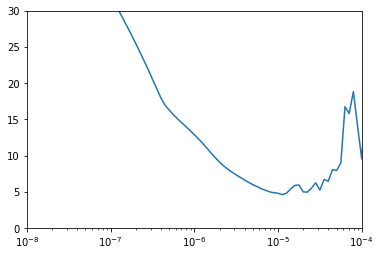

In [26]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [40]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16    # 적용 결과 loss의 스파크가 약간 줄었음, mae 자체는 증가 
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1,    # 커널 사이즈 수정 
                           padding='causal', activation= 'relu', input_shape=[None, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),    # Bidirectional 안썼을 때 
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x*200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(optimizer, tf.keras.losses.Huber(), metrics=['mae'])
history = model.fit(dataset, epochs=500)

Epoch 1/500
61/61 [==============================] - 3s 7ms/step - loss: 26.1087 - mae: 26.6019
Epoch 2/500
61/61 [==============================] - 1s 8ms/step - loss: 7.0069 - mae: 7.4902
Epoch 3/500
61/61 [==============================] - 1s 7ms/step - loss: 5.8911 - mae: 6.3711
Epoch 4/500
61/61 [==============================] - 1s 7ms/step - loss: 5.5388 - mae: 6.0172
Epoch 5/500
61/61 [==============================] - 0s 7ms/step - loss: 5.3421 - mae: 5.8217
Epoch 6/500
61/61 [==============================] - 1s 8ms/step - loss: 5.3579 - mae: 5.8372
Epoch 7/500
61/61 [==============================] - 1s 8ms/step - loss: 5.3567 - mae: 5.8364
Epoch 8/500
61/61 [==============================] - 1s 8ms/step - loss: 5.0045 - mae: 5.4826
Epoch 9/500
61/61 [==============================] - 0s 7ms/step - loss: 5.1763 - mae: 5.6558
Epoch 10/500
61/61 [==============================] - 0s 7ms/step - loss: 4.9561 - mae: 5.4351
Epoch 11/500
61/61 [==============================] - 0s 

In [41]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

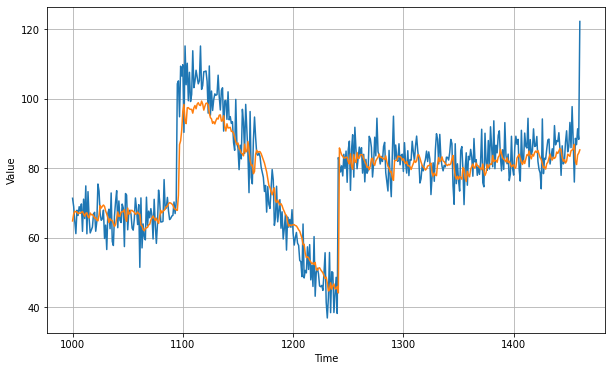

In [42]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [43]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.1596603

<Figure size 432x288 with 0 Axes>

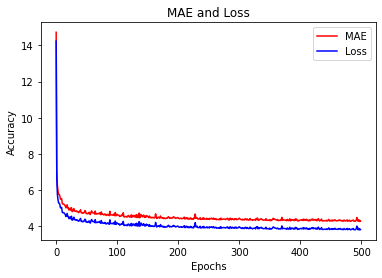

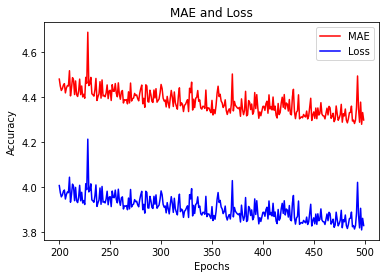

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()